In [1]:
# note - the old notebook is located at ../school/ai-capstone/CTD_Parkinsons.ipynb
# note - read this for better evaluation metrics https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba

In [2]:
import os
import requests

import numpy as np
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, Normalization, Conv1D, Dropout, MaxPool2D,MaxPooling1D, Flatten
from keras.models import Model

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [3]:
VERBOSE=False
EPOCHS=25
TRAIN_SIZE=.7

## This cell will defines a function used to download files from CTD

In [4]:
import gzip
import shutil

def download_resource(resource):
    url_dl_pattern = 'http://ctdbase.org/reports/{resource}.csv.gz'
    url = url_dl_pattern.format(resource=resource)
    
    print('downloading: {0}'.format(resource))
    local_filename = 'zipped_data/' + url.split('/')[-1]
    unzipped_filename = 'unzipped_data/' + url.split('/')[-1].replace('.gz', '')
    
    if os.path.isfile(unzipped_filename):
        print('data already exists')
        return 

    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)

    with gzip.open(local_filename, 'rb') as f_in:
        with open(unzipped_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    return local_filename


## Here we download all of the files we'll need from CTD

In [5]:

resources = [
#     'CTD_chem_gene_ixn_types',
#     'CTD_chem_pathways_enriched',
#     'CTD_genes_diseases',
#     'CTD_genes_pathways',
#     'CTD_diseases_pathways',
#     'CTD_pheno_term_ixns',
#     'CTD_exposure_studies',
#     'CTD_chemicals',
#     'CTD_genes',
    'CTD_chem_gene_ixns',
    'CTD_chemicals_diseases',
    'CTD_diseases'
]

for res in resources:
    download_resource(res)


downloading: CTD_chem_gene_ixns
data already exists
downloading: CTD_chemicals_diseases
data already exists
downloading: CTD_diseases
data already exists


## This function allows us to pull one of the files into a dataframe from local storage

In [6]:
def get_df(resource):
    line_number = 27
    the_file = 'unzipped_data/{resource}.csv'.format(resource=resource)
    with open(the_file, 'r') as reader:
        for i, row in enumerate(reader):
            if i == line_number:
                header = row.replace('# ', '').split(',')

    # print(header)
    df = pd.read_csv(the_file, skiprows=29, names=header)
    return df

## In this block, we find all of the diseases that we want to use in our algorithm.  We look for three depths of the hierarchy then define all the gene networks for all those diseases, so we can use those as the target labels in our classifier.

In [7]:
disease_df = get_df('CTD_diseases')
disease_df['ParentIDs'].str.split('|').explode()

hierarchy_df = disease_df\
    .assign(ParentIDs=disease_df['ParentIDs'].str.split('|')).explode('ParentIDs')

# top_of_tree = 'MESH:D010300' # parkinsons disease
# top_of_tree = 'MESH:D020734' # Parkinsonian Disorders
top_of_tree = 'MESH:D019636' # neurodegenerative diseases
# top_of_tree = 'MESH:D009422' # nervous system diseases
level_one = hierarchy_df.loc[hierarchy_df['ParentIDs'] == top_of_tree]
level_two = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_one['DiseaseID'])]
level_three = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_two['DiseaseID'])]

# to do, do this recursively..
all_diseases = list(level_one['DiseaseID'].unique()) \
             + list(level_two['DiseaseID'].unique()) \
             + list(level_three['DiseaseID'].unique()) \
             + [top_of_tree]


## Here we find the top N genes in the network by frequency.  By using all of the genes in the network the matrix is far too sparse so we chose N genes to reduce the number of features that we'll use for the classification

In [8]:
def get_genes(df, N):
    gene_df = pd.DataFrame(df.groupby(['InferenceGeneSymbol']).size()).reset_index()
    gene_df.columns = ['InferenceGeneSymbol','cnt']
    print(len(gene_df))
    top_n_genes_df = gene_df.sort_values('cnt', ascending=False)[:N]
    top_n_genes = top_n_genes_df['InferenceGeneSymbol'].unique()
    
    return top_n_genes
    ## HERE WE ADD ALL THE GENES IN THE PARKINSONS NETWORK
    # genes_in_diseases = df[df['DiseaseID'].isin(all_diseases)]['InferenceGeneSymbol'].unique()
    
    # unique_list_of_genes = list(set(list(top_n_genes) + list(genes_in_diseases)))
    # return [x for x in unique_list_of_genes if type(x) == str]

df = get_df('CTD_chemicals_diseases')
N = 1000
top_500_genes = get_genes(df, N)

print(len(top_500_genes))

8674
1000


## In this function we take the chemical_disease interaction dataset and create N features for the N genes we've defined above.  There are two types of rows in this dataset -- one with no gene interactions and  "direct evidence" field of either "marker/mechanism" or "therapeutic".  Then we have rows for every gene interaction in the network.  

## We split the data set up into these two derivations and join them together on chemical/disease to be able to apply the inference score from the gene rows.  The idea here is we're trying to recreate the way the dataset looks [here](http://ctdbase.org/detail.go?type=disease&acc=MESH%3AD010300&view=chem)


In [9]:
def get_training_data(df, top_n_genes, use_fs=False):
    
    if use_fs:
        try:
            return pd.read_csv('gene_network.csv')
        except Exception:
            pass

    gene_df = df.loc[df['DirectEvidence'].isnull()][['ChemicalName', 'DiseaseName', 'InferenceGeneSymbol', 'InferenceScore', 'DiseaseID']]

    gene_df = gene_df.loc[gene_df['InferenceGeneSymbol'].isin(top_n_genes)]

    evidence_df = df.loc[df['DirectEvidence'].notnull()][['ChemicalName', 'DiseaseName', 'DirectEvidence', 'DiseaseID']]
    merged_df = gene_df.merge(evidence_df, on=['ChemicalName', 'DiseaseName', 'DiseaseID'])

    dummy_df = pd.get_dummies(merged_df, prefix='', prefix_sep='',columns=['InferenceGeneSymbol'])
    gb_df = dummy_df.groupby(['DiseaseName', 'ChemicalName', 'DiseaseID']).agg({np.max}).reset_index()

    gb_df.columns = gb_df.columns.droplevel(1)

    gb_df['label'] = np.where(gb_df['DirectEvidence'] == 'marker/mechanism',
                                               gb_df['InferenceScore'] * -1,
                                               gb_df['InferenceScore'])

    if use_fs:
        gb_df.to_csv('gene_network.csv')
        
    return gb_df
    
train_df = get_training_data(df, top_n_genes=top_500_genes, use_fs=False)
    

In [10]:
# print(train_df.DiseaseName.unique())

## Here we define a binary label based on the presence of the diseases we've selected above ... that is all the neruodegenerative disease / gene interactions will have a 1 and all the other interactions will ahve a zero.

In [11]:
train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(all_diseases),1, 0)
print(train_df.groupby(['binary_label']).size())

print('\n predicting the following diseases:\n', ', '.join(train_df[train_df['DiseaseID'].isin(all_diseases)]['DiseaseName'].unique()))

len(train_df.columns)

binary_label
0    51267
1      525
dtype: int64

 predicting the following diseases:
 Adrenoleukodystrophy, Alzheimer Disease, Amyloid Neuropathies, Familial, Amyotrophic Lateral Sclerosis, Amyotrophic lateral sclerosis 1, Ceroid Lipofuscinosis, Neuronal, 6, Ceroid lipofuscinosis, neuronal 1, infantile, Charcot-Marie-Tooth Disease, Cockayne Syndrome, Copper-Overload Cirrhosis, Creutzfeldt-Jakob Syndrome, Familial apoceruloplasmin deficiency, Fragile X Syndrome, Frontotemporal Dementia, Hepatolenticular Degeneration, Huntington Disease, Lewy Body Disease, Menkes Kinky Hair Syndrome, Motor Neuron Disease, Myasthenia Gravis, Neurodegenerative Diseases, Neuromyelitis Optica, Optic Atrophy, Hereditary, Leber, Parkinson Disease, Prion Diseases, Rett Syndrome, Scrapie, Shy-Drager Syndrome, Supranuclear Palsy, Progressive, Tauopathies, Tourette Syndrome, Tuberous Sclerosis


1007

### Here we plot the accuracy / loss / ROC curve and confusion matrix 

In [12]:
def plot_results(history, predicted_values, y_test, accuracy, show_plots=True):

    auc_score = roc_auc_score(y_test, predicted_values) 

    if show_plots:
        # plot accuracy
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes[0][0].plot(history.history['accuracy'],label='accuracy')
        axes[0][0].plot(history.history['val_accuracy'],label='val_accuracy')
        axes[0][0].text(2, history.history['accuracy'][0] + .005, 'accuracy: {:.4f}'.format(accuracy))

        axes[0][0].legend()


        # plot loss
        axes[0][1].plot(history.history['loss'],label='loss')
        axes[0][1].plot(history.history['val_loss'],label='val_loss')
        axes[0][1].legend()
        fig.tight_layout()

        fpr, tpr, thresholds = roc_curve (y_test , predicted_values)

        # plot_roc_curve

        axes[1][0].plot(fpr,tpr)
        axes[1][0].text(0.7, 0.9, 'auc: {:.4f}'.format(auc_score))
        axes[1][0].axis([-.05,1.1,0,1.05]) 

        # plot confusion matrix
        cm = confusion_matrix(y_test, np.where(predicted_values > 0.5, 1, 0))

        labels = ["Non Target", "Target"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues, ax=axes[1][1]) # xticks_rotation=45

    return auc_score

### This is a simple DNN model that predicts our binary labels and plots the results

2022-02-26 20:42:28.050363: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


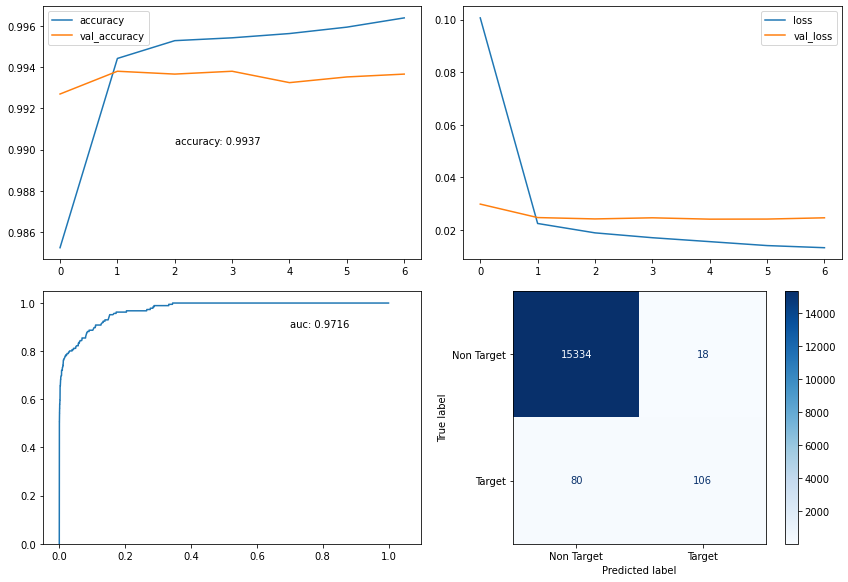

In [13]:
def simple_model(features, labels, stop_early=True, show_plots=True):
    
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

#     print(len(X_train))
#     print(len(X_test))
#     print(len(y_train))
#     print(len(y_test))
    
    model = Sequential()
    model.add(Dense(60, input_dim=input_shape, activation='relu'))
    model.add(Dense(6, input_dim=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    callbacks = []
    if stop_early:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

    history = model.fit(X_train,
                        y_train,
                        epochs=25,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=VERBOSE
                       )
    predicted_values = model.predict(X_test)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
    
    auc = plot_results(history, predicted_values, y_test, accuracy, show_plots)
    
    
    return history, model, auc
  

gene_columns = train_df.columns.intersection(top_500_genes)
shuffled_df = train_df.sample(frac=1)
history, the_simple_model, auc = simple_model(shuffled_df[gene_columns], shuffled_df['binary_label'])



## here we use a CNN and re-use the evaluation functions that we had above

486/486 [==============================] - 2s 5ms/step - loss: 0.0273 - accuracy: 0.9927


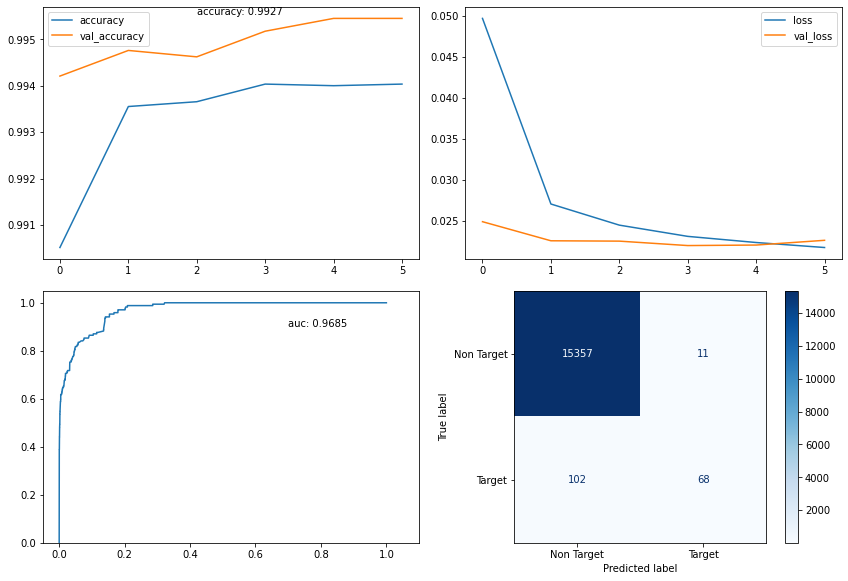

In [14]:
def cnn_model(features, labels, stop_early=True):
    layer_numbers = 2        
    pct_nodes_to_drop = .2
    model = Sequential()

    model.add(Conv1D(64, 2, activation="relu", input_shape=(len(features.columns),1)))
    model.add(Dense(16, activation="relu"))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    # model.summary()

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)
    
    callbacks = []
    if stop_early:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=VERBOSE
                       )
    predicted_values = model.predict(X_test)
    loss, accuracy = model.evaluate(X_test, y_test)
    auc = plot_results(history, predicted_values, y_test, accuracy, show_plots=True)
    return history, model, auc


gene_columns = train_df.columns.intersection(top_500_genes)
shuffled_df = train_df.sample(frac=1)
history, the_simple_model, auc = cnn_model(shuffled_df[gene_columns], shuffled_df['binary_label'])



### Now we're going to try to evaluate the positives and negative gene network relations -- we don't just want to predict inference we want to predcit what gene chemical interactions have positive and negative inference on the network

/var/folders/p5/xcpfglq9557_4508swyt2gn40000gn/T/ipykernel_28635/2365394132.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  labels = enc.fit_transform(shuffled_df['categorical_label'][:, np.newaxis]).toarray()


486/486 [==============================] - 0s 908us/step - loss: 0.0326 - accuracy: 0.9927


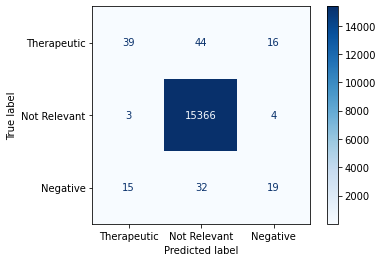

In [15]:
def apply_category(row):
    if row.binary_label == 0:
        return 'Not Releveant'
    if row.DirectEvidence == 'marker/mechanism':
        return 'Negative'
    else:
        return 'Therapeutic'

def categorical_prediction(features, labels, stop_early=True):
    
    input_shape = features.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

    model = Sequential()
    model.add(Dense(60, input_dim=input_shape, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    callbacks = []
    if stop_early:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

    history = model.fit(X_train,
                        y_train,
                        epochs=25,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=VERBOSE
                       )
    predicted_values = model.predict(X_test)
    loss, accuracy = model.evaluate(X_test, y_test)

    cm = confusion_matrix(y_test.argmax(axis=1), predicted_values.argmax(axis=1))

    labels = ['Therapeutic', 'Not Relevant', 'Negative']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap=plt.cm.Blues) # xticks_rotation=45
    # plot_results(history, predicted_values, y_test, accuracy)

    return model

train_df = get_training_data(df, top_500_genes)
# print(train_df[:4])
train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(all_diseases),1, 0)

shuffled_df = train_df.sample(frac=1)

shuffled_df['categorical_label'] = shuffled_df.apply(lambda row: apply_category(row), axis=1)

enc = OneHotEncoder()
labels = enc.fit_transform(shuffled_df['categorical_label'][:, np.newaxis]).toarray()
 
    
gene_columns = train_df.columns.intersection(top_500_genes)

the_multi_class_model = categorical_prediction(shuffled_df[gene_columns], labels)


## Here, we Determine the optimal number of genes to use in the matrix  -- we've started with 500 but we want to 

In [16]:
# gene_counts = range(50, 5050, 500)
gene_counts = []

df = get_df('CTD_chemicals_diseases')

results = []
for gc in gene_counts:
    print('gc:', gc)
    top_n_genes = get_genes(df, gc)
    gene_columns = train_df.columns.intersection(top_n_genes)
    
    train_df = get_training_data(df, top_n_genes)
    
    train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(all_diseases),1, 0)
      
    shuffled_df = train_df.sample(frac=1)
    
    history, model, auc = simple_model(shuffled_df[gene_columns], shuffled_df['binary_label'], show_plots=False)
    results.append({
        'history': history, 
        'model': model,
        'auc': auc,
        'gene_count': gc
    })

## now plot these


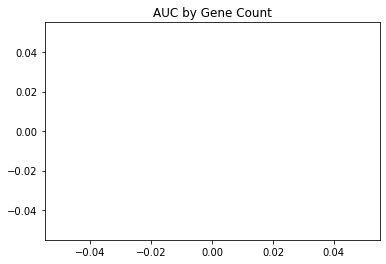

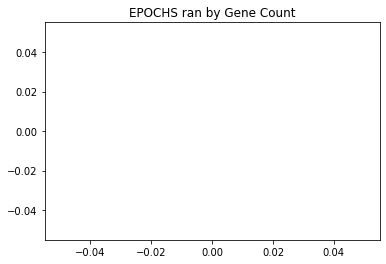

In [17]:
# # for x in results:
x = [x.get('gene_count') for x in results]
y = [x.get('auc') for x in results]

y2 = [len(x.get('history').history.get('loss')) for x in results]

# # x = [x.get('gene_count' for x in results)]
# # y = [_.get('auc' for _ in results)]
plt.plot(x, y)
plt.title('AUC by Gene Count')
plt.show()

plt.plot(x, y2)
plt.title('EPOCHS ran by Gene Count')
plt.show()




### Here we evaluate the chemicals that have posibile therapeutic and harmful effects as it relates to.  We take the chemical to gene network.  I want to see chemicals *not* in the dataset that we can research.

In [18]:
inp_df = get_df('CTD_chem_gene_ixns')
inp_df = inp_df[inp_df['GeneSymbol'].isin(top_500_genes)]


gb_df = inp_df.groupby(['ChemicalName', 'GeneSymbol']).size().reset_index()
gb_df.columns = ['ChemicalName','GeneSymbol', 'InteractionCount']
dummy_df = pd.get_dummies(gb_df, prefix='', prefix_sep='',columns=['GeneSymbol'])

gb_df = dummy_df.groupby(['ChemicalName']).agg({np.max}).reset_index()
gb_df.columns = gb_df.columns.droplevel(1)



In [28]:
gb_df
# features = gb_df.drop(['ChemicalName','InteractionCount'], axis=1)
predicted_values = the_multi_class_model.predict(gb_df[gene_columns])

predicted_value_df = pd.DataFrame(predicted_values, columns=['Ther', 'Not Relevant', 'Marker'])

final = gb_df.merge(predicted_value_df, left_index=True, right_index=True)
final = final[['ChemicalName', 'Ther', 'Not Relevant', 'Marker']]

# print('--- THER ---')
# final.nlargest(10, 'Ther')
# print(final.sort_values('Ther', ascending=False))[:5]

print('--- MARKER ---')
final.nlargest(10, 'Marker')



ValueError: in user code:

    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/john/code/gene-graph/venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 1000), found shape=(None, 100)


In [29]:
interesting_chemicals = ['Oxidopamine', 'Melatonin', 'Maneb', '1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine']
interesting_df = final[final['ChemicalName'].isin(interesting_chemicals)]
print(interesting_df)

                                      ChemicalName  Ther  Not Relevant  Marker
396   1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine   0.0           1.0     0.0
5171                                         Maneb   0.0           1.0     0.0
5205                                     Melatonin   0.0           1.0     0.0
5990                                   Oxidopamine   0.0           1.0     0.0


## look at feature importance

8674
100


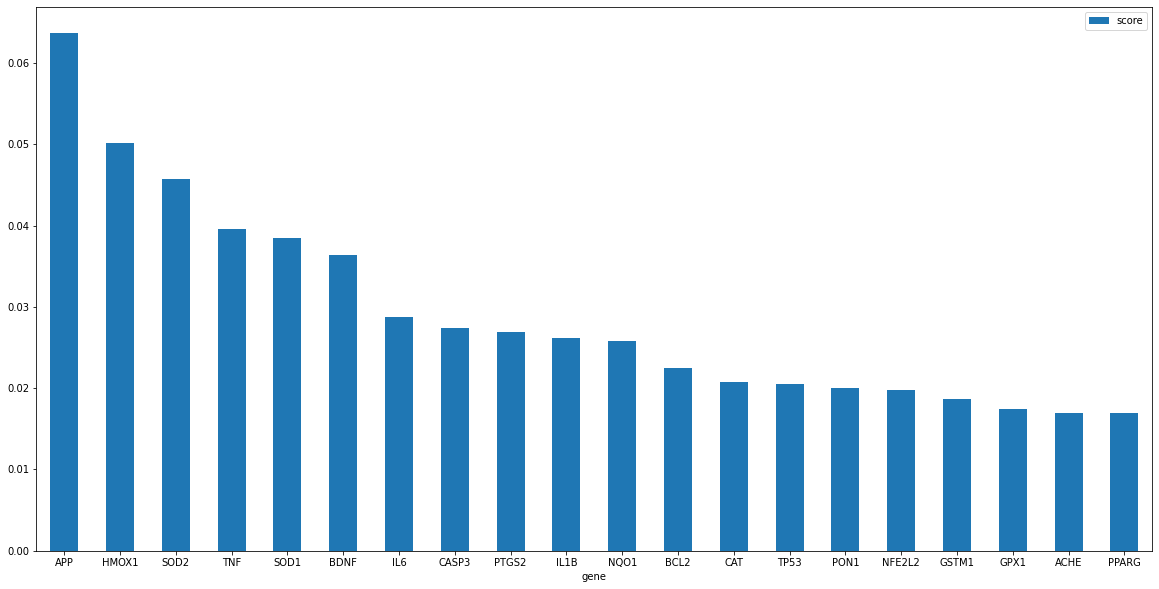

In [21]:
from sklearn.ensemble import RandomForestClassifier


def feature_importance(features, labels, stop_early=True, show_plots=True):
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

    rand_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rand_forest_classifier.fit(X_train, y_train)

    optimal_node_count = 128
    feature_count = 70
    output_label_len = 10
    imp_arr = rand_forest_classifier.feature_importances_
    
    gene_importance = dict(zip(features.columns, imp_arr))
    gene_importance_df = pd.DataFrame({'gene': features.columns, 'score': imp_arr})

    return gene_importance_df.sort_values('score', ascending=False)
    
    
top_100_genes = get_genes(df, 100)
gene_columns = train_df.columns.intersection(top_100_genes)
print(len(gene_columns))
shuffled_df = train_df.sample(frac=1)
gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])


## https://www.nature.com/articles/ng0892-345 # APP shows up... has strong inference to alzheimers
# gene_importance_df.hist()

ax = gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))

## gradient boosted trees

In [22]:
# from sklearn.ensemble import GradientBoostingClassifier

# class EmptyHistoryObject:
#     def __init__(self):
#         self.history = {'accuracy':[0], 'val_accuracy':[0],'loss':[0],  'val_loss':[0]}
# h = EmptyHistoryObject()

# # h.history['accuracy']

# def gradient_boosted_tree(features, labels, stop_early=True, show_plots=True):
#     input_shape = features.shape[1]
    
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=.2)

#     clf = GradientBoostingClassifier(
#          n_estimators=500,
#          learning_rate=.1,
#          max_depth=50,
#          max_features='auto',
#          random_state=1).fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)

#     predicted_values = clf.predict(X_test)
#     auc = plot_results(h, predicted_values, y_test, accuracy, show_plots=True)
    
#     return accuracy
    
    
# gene_columns = train_df.columns.intersection(top_500_genes)
# shuffled_df = train_df.sample(frac=1)
# # history, gradient_boosted_tree, auc = simple_model(shuffled_df[gene_columns], shuffled_df['binary_label'])
# acc = gradient_boosted_tree(shuffled_df[gene_columns], shuffled_df['binary_label'])


## lets see if we can get any performance out of dimensionality reduction w PCA

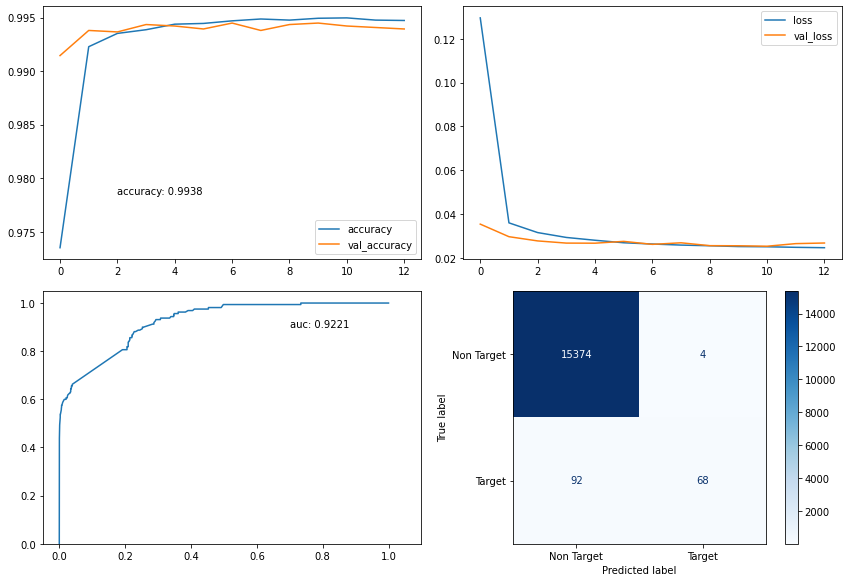

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca_features = pca.fit_transform(shuffled_df[gene_columns])
history, gradient_boosted_tree, auc = simple_model(pca_features, shuffled_df['binary_label'])




In [24]:
# before finishing
#  - better metrics, precision / recall and other measures for imbalanced dataset

In [25]:
## future work 
# - use gene pathways, potentially with LSTM 
# - iterate of gene importance to do a better job at selecting features
# - experiment with dimesionality reduction
# - use regression models